In [1]:
import sys
sys.path.insert(0, "/Users/simon/Library/CloudStorage/GoogleDrive-simon.tait@ligo.org/My Drive/BackupFromDropbox/Obsidian/Caltech Vault/Coatings_Simulations/Reinforcement_Learning/coatopt/src")

import coatopt
print("coatopt from:", coatopt.__file__)


from coatopt.algorithms import hppo
from coatopt.environments.multiobjective_environment import MultiObjectiveEnvironment
from coatopt.config import read_config, read_materials
#from coatopt.train_coating_hppo import training_loop
#from coatopt.tools import plotting, genetic_tools
import os
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import matplotlib.pyplot as plt
import copy
import h5py
import pandas as pd
import pickle

coatopt from: None


In [2]:


%matplotlib widget

In [2]:
def make_state_from_genetic_vars(vars: np.ndarray, max_layers: int=20, n_materials: int=4) -> np.ndarray:
    """
    Convert optimisation variables to coating state representation.
    
    Args:
        vars: optimisation variables [thicknesses..., materials...]
        
    Returns:
        State array with shape (max_layers, n_materials+1)
    """
    state = np.zeros((max_layers, n_materials + 1))
    layer_thickness = vars[:max_layers]
    materials_inds = np.floor(vars[max_layers:]).astype(int)
    
    for i in range(max_layers):
        state[i, 0] = layer_thickness[i]
        # Add 2 to account for air (0) and substrate (1) indices
        state[i, materials_inds[i] + 2] = 1
        
    return state

In [3]:
def plot_stack(data, materials, rewards=None, vals=None, ax=None):
    """
    Plot coating stack visualization showing layer thickness and materials.
    
    Args:
        data: Array with coating layer data (thickness and material encoding)
        materials: List of material dictionaries with properties
        rewards: Optional reward dictionary for title display
        vals: Optional values dictionary for title display  
        ax: Optional matplotlib axis to plot on
        
    Returns:
        fig, ax: Matplotlib figure and axis objects
    """
    # Extract the layers and their properties
    L = data.shape[0]
    thickness = data[:, 0]
    colors = []
    nmats = data.shape[1] - 1

    # Define colors for m1, m2, and m3
    color_map = {
        0: 'gray',    # air
        1: 'blue',    # m1 - substrate
        2: 'green',   # m2
        3: 'red',      # m3
        4: 'black',
        5: 'yellow',
        6: 'orange',
        7: 'purple',
        8: 'cyan',
    }

    labels = []
    for row in data:
        row = np.argmax(row[1:])
        if row == 0:
            colors.append(color_map[0])  # m1
            labels.append(f"{materials[0]['name']}")
        else:
            colors.append(color_map[row])  # m2
            labels.append(f"{materials[row]['name']} (1/4 wave{1064e-9 /(4*materials[row]['n'])})")

    # Create a bar plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig=None
    #bars = ax.bar(range(L), thickness, color=colors)
    bars = [ax.bar(x, thickness[x], color=colors[x], label=labels[x]) for x in range(L)]

    # Add labels and title
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Thickness')
    if rewards is not None:
        ax.set_title(f'TR: {rewards["total_reward"]}, R: {vals["reflectivity"]:.8f}, T: {vals["thermal_noise"]:.8e}, A: {vals["absorption"]:.8e}')
    ax.set_xticks(range(L), [f'Layer {i + 1}' for i in range(L)])  # X-axis labels

    #  Show thickness values on top of bars
    #for x, bar in enumerate(bars):
    #    yval = thickness[x]
    #    ax.text(bar[0].get_x() + bar[0].get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom')

    ax.set_ylim(0, np.max(thickness)*(1.1) )  # Set Y-axis limit
    ax.grid(axis='y', linestyle='--')

    unique_labels = dict(zip(labels, colors))
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
            for label, color in unique_labels.items()]
    ax.legend(handles=handles, title="Materials")

    return fig, ax


In [4]:
materials = {
    0: {
        "name": "air",
        "n": 1,
        "a": 0,
        "alpha": np.nan,
        "beta": np.nan,
        "kappa": np.nan,
        "C": np.nan,
        "Y": np.nan,
        "prat": np.nan,
        "phiM": np.nan,
        "k": 0
    },
    999: {
        'name' : 'air',
        'n'    : 1,
        'a'    : np.nan,
        'alpha': np.nan,
        'beta' : np.nan,
        'kappa': np.nan,
        'C'    : np.nan,
        'Y'    : np.nan,
        'prat' : np.nan,
        'phiM' : np.nan,
    }, 
    
    1: {
        "name" : "SiO2",
        "n"    : 1.45,
        "a"    : 0,
        "alpha": 0.51e-6, 
        "beta" : 8e-6,    
        "kappa": 1.38,
        "C"    : 1.64e6,  
        "Y"    : 70e9,    
        "prat" : 0.17,
        "phiM" : 2.3e-5,   

        "k"    : 3E-8    
            
    },
    2: {
        "name" : "Ti:Ta2O5",
        "n"    : 2.09,
        "a"    : 2,
        "alpha": 3.6e-6,    
        "beta" : 14e-6,     
        "kappa": 33,        
        "C"    : 2.1e6,      
        "Y"    : 120e9,      
        "prat" : 0.23,
        "phiM" : 2.3E-4,  
        "k"    : 5E-8    
        
    },
       3: { 
        'name' : 'aSi',
        'desc' : 'amorphous silicon - room temperature - Ion Planting',
        'n'    : 3.73,  # Tait et al 2020 
        'a'    : 10,    # Tait et al 2020 
        'alpha': 2e-6,  # Tait et al 2020 
        'beta' : 10e-6, # Tait et al 2020 
        'kappa': 30,    # Tait et al 2020 
        'C'    : 2.0e6, # Tait et al 2020 
        'Y'    : 147e9, # Tait et al 2020 
        'prat' : 0.23,  # Tait et al 2020 
        'phiM' : 2e-5,  # Tait et al 2020 - optimum annealing loss at 500C
        'phiM' : 4.5E-5,  # UCB - Hydrogenated aSi 
        
        # 'k'    : 5E-3, # Tait et al 2020 - calculated from lower stack assumiung that silica absorption is negligable 
        'k'    : 7.6E-5 # UCB - Hydrogenated aSi 
        
    },
}

In [5]:
####################
## Change the root dir path to one of the hppo_20layer/50layer/20layer_3objective
######################

# 2 targets 20 layer
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_6_opticalthickness_logtarget_weightsmultiicycle_lstmweight_long_cumulativesave2"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_6_opticalthickness_logtarget_weightsmultiicycle_lstmweight_long_cumulativesave2_decentropy"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_8_opticalthickness_logtarget_weightsmultiicycle_lstmweight_long_cumulativesave2_decentropy"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightscycle_lstmweight_long_cumulativesave2"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightscycle_lstmweight_long_cumulativesave2_air3"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightscycle_lstmweight_long_cumulativesave2_air3_repeat"

# 2 targets 20 layer with random weights
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightsrandom_lstmweight_long_cumulativesave2_air3_repeat"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightsannealed_lstmweight_long_cumulativesave2_air3_repeat"

# 3 targets 20 layer
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_20layer_8_3logtarget_weightsmultiicycle_lstmweight_long_cumulativesave2_decentropy"

# 2 targets 50 layer
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_50layer_7_opticalthickness_distance_weightscycle_lstmweight_long_cumulativesave2_air3_ab1_64update"
root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/oml_pc_hppo_pareto_50layer_6_opticalthickness_distance_weightscycle_lstmweight_long_cumulativesave2_air3"

# hyper networks
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/hyperoml_pc_hppo_pareto_20layer_1_opticalthickness_distance_weightscycle_lstmweight_long_cumulativesave2_air3"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/hyperoml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightsrand_lstmweight_long_cumulativesave2_air3"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/hyperoml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightslinear_lstmweight_long_cumulativesave2_air3"
#root_dir = "/Users/joebayley/projects/coating_optimisation/outputs_3material/hyperoml_pc_hppo_pareto_50layer_1_opticalthickness_distance_weightscycle_lstmweight_long_cumulativesave2_air3"

# refactor path
#root_dir = "/Users/joebayley/projects/coating_optimisation/refactor_outputs/oml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightscycle_lstmweight_long_cumulativesave2_air3_repeat2"
#root_dir = "/Users/joebayley/projects/coating_optimisation/refactor_outputs/oml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightscycle_attnweight_long_cumulativesave2_air3_repeat2"
#root_dir = "/Users/joebayley/projects/coating_optimisation/refactor_outputs/oml_pc_hppo_pareto_20layer_6_opticalthickness_distance_weightscyclefast_attnweight_long_cumulativesave2_air3_repeat2"

#root_dir = "/Users/joebayley/projects/coating_optimisation/refactor_outputs/oml_pc_hppo_pareto_20layer_28_airpenalty_log4_divergencemin_adnorm_smoothw_lstm_air"



root_dir ="/Users/simon/Library/CloudStorage/GoogleDrive-simon.tait@ligo.org/My Drive/BackupFromDropbox/Obsidian/Caltech Vault/Coatings_Simulations/Reinforcement_Learning/data_simon/hppo_50layer"

with h5py.File(os.path.join(root_dir, "sampled_outputs.h5"), "r") as f:
    states = f["states"][:]
    weights = f["weights"][:]
    total_rewards = f["total_reward_rewards"][:]
    reflectivity_rewards = f["reflectivity_rewards"][:]
    thermal_noise_rewards = f["thermal_noise_rewards"][:]
    absorption_rewards = f["absorption_rewards"][:]
    thickness_rewards = f["thickness_rewards"][:]
    reflectivity_vals = f["reflectivity_vals"][:]
    thermal_noise_vals = f["thermal_noise_vals"][:]
    absorption_vals = f["absorption_vals"][:]
    thickness_vals = f["thickness_vals"][:]

with open(os.path.join(root_dir, "best_states.pkl"), "rb") as f:
    best_states = pickle.load(f)


In [6]:
# Perform non-dominated sorting
nds = NonDominatedSorting()
rref = 1-reflectivity_vals
rwds = np.array([rref, absorption_vals]).T
val_fronts = nds.do(rwds)

# Extract the best Pareto front (the first front)
best_val_front = val_fronts[0]
print(best_val_front)

[ 52  67 138 153 173 177 230 231 250 274 323 324 351 366 379 449 456 512
 599 642 681 733 736 767 812 830 834 847 849 864 911 983]


In [7]:
all_points = np.array([[1-bs[4]["reflectivity"], bs[4]["absorption"]] for bs in best_states])
# Perform non-dominated sorting
nds2 = NonDominatedSorting()
val_fronts_all = nds2.do(all_points)

# Extract the best Pareto front (the first front)
best_val_front_all = val_fronts_all[0]
print(best_val_front_all)

[3672 4338 4358 4362 5325 5861 5934 5988 6023 6028 6047 6059 6068 6077
 6094 6152 6181 6228 6238 6240]


In [8]:
cumulative_pareto_states = [best_states[i][2] for i in val_fronts_all[0]]

In [9]:
##########
# Read in the moead and ngsa outputs (you will need to change paths)
############

base_dir = "/Users/simon/Library/CloudStorage/GoogleDrive-simon.tait@ligo.org/My Drive/BackupFromDropbox/Obsidian/Caltech Vault/Coatings_Simulations/Reinforcement_Learning/data_simon"

moead_output = pd.read_csv(os.path.join(base_dir, "moead_20layer/optimised_data.csv"))
ngsa_output = pd.read_csv(os.path.join(base_dir, "ngsa_20layer/optimised_data.csv"))
#ngsa_output = pd.read_csv("/Users/joebayley/projects/coating_optimisation/outputs_3material/ngsa2_20layer_target_air2/optimised_data.csv")

In [10]:
ngsa_states = []
for ind, val in ngsa_output.iterrows():
    ngsa_states.append(make_state_from_genetic_vars(val, max_layers=20, n_materials=4))

/var/folders/kl/zlts2c4d0kvfmvbklktb9p5r0000gn/T/ipykernel_23453/617394839.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state[i, 0] = layer_thickness[i]
/var/folders/kl/zlts2c4d0kvfmvbklktb9p5r0000gn/T/ipykernel_23453/617394839.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state[i, materials_inds[i] + 2] = 1
/var/folders/kl/zlts2c4d0kvfmvbklktb9p5r0000gn/T/ipykernel_23453/617394839.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

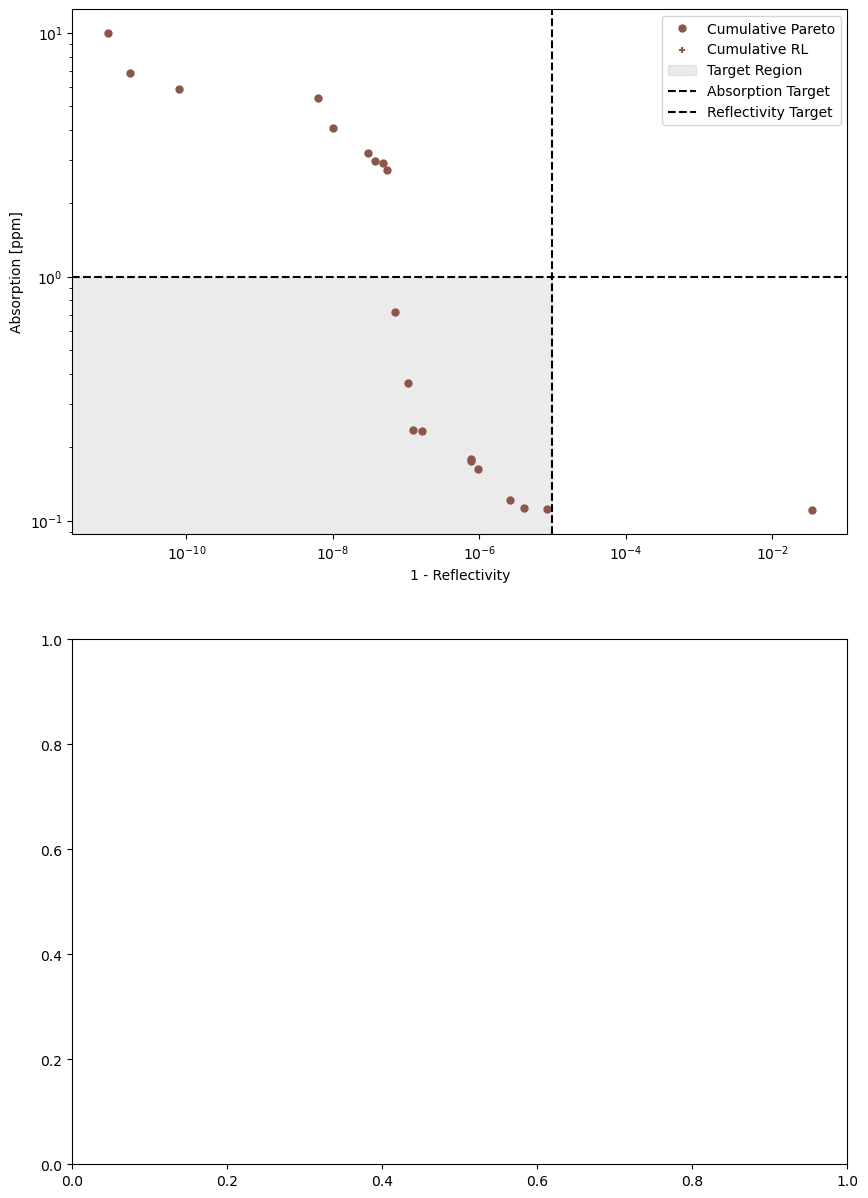

In [11]:
fig, ax = plt.subplots(figsize=(10, 15), nrows=2)
plot_sampled = False
if plot_sampled:
    ax[0].scatter(rwds[:,0], rwds[:,1], c="r", s=1, label="Samples All", alpha=0.2)
    ax[0].plot(rwds[val_fronts[0], 0], rwds[val_fronts[0], 1], label=f"Sampled Pareto", ms=10, color="r", marker=".", ls="none")

plot1 = ax[0].plot(all_points[val_fronts_all[0], 0], all_points[val_fronts_all[0], 1], label=f"Cumulative Pareto", ms=10, color="C5", marker=".", ls="none", picker=True)

scatter1 = ax[0].scatter(all_points[val_fronts_all[0], 0], all_points[val_fronts_all[0], 1], label=f"Cumulative RL", c="C5", s=20, picker=True,marker="+")
#ax[0].scatter(all_points[:, 0], all_points[:, 1], label=f"Cumulative RL", s=1, color="C5", alpha=0.2)
# scatter2 = ax[0].scatter(1-ngsa_output["Reflectivity"], ngsa_output["Absorption"], c="g", s=20, label="NGSAII", picker=True, alpha=0.5, marker="+")

# scatter3 = ax[0].scatter(1-moead_output["Reflectivity"], moead_output["Absorption"], c="c", s=20, label="MOEAD", picker=True)
#plot2 = ax[0].plot(1-ngsa_output["Reflectivity"], ngsa_output["Absorption"], label="NGSAII", ms=10, color="g", marker=".", ls="none", picker=True)

# Shade the region to the bottom left of the targets
x_target = 1 - 0.99999
y_target = 1
ax[0].fill_between(
    [ax[0].get_xlim()[0], x_target],  # x range from left to target
    ax[0].get_ylim()[0], y_target,    # y range from bottom to target
    color="k", alpha=0.08, label="Target Region"
)
ax[0].axhline(y_target, label="Absorption Target", color="k", linestyle="--")
ax[0].axvline(x_target, label="Reflectivity Target", color="k", linestyle="--")

ax[0].set_xlabel("1 - Reflectivity")
ax[0].set_ylabel("Absorption [ppm]")

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend()

# Define the event handler
def on_pick(event):
    ind = event.ind[0]
    print(ind, event.artist)
    # Remove previous red circle if it exists
    if hasattr(on_pick, "last_circle") and on_pick.last_circle is not None:
        on_pick.last_circle.remove()
        on_pick.last_circle = None

    # Draw new red circle
    if event.artist == scatter1:
        on_pick.last_circle = ax[0].scatter(all_points[val_fronts_all[0], 0][ind], all_points[val_fronts_all[0], 1][ind], s=100, 
                                                facecolors='none', edgecolors='red', linewidths=2, zorder=10)
        state = cumulative_pareto_states[ind]
    
    # elif event.artist == scatter2:
    #     on_pick.last_circle = ax[0].scatter(1-ngsa_output["Reflectivity"][ind], ngsa_output["Absorption"][ind], s=100, 
    #                                         facecolors='none', edgecolors='g', linewidths=2, zorder=10)
        # state = ngsa_states[ind]
    else:
        return
    
    ax[1].cla()
    plot_stack(state, materials, ax=ax[1])

    fig.canvas.draw()


fig.canvas.mpl_connect('pick_event', on_pick)
plt.show()

## Updateing Plots to use CoatDef


In [12]:
!python -m pip install tqdm-joblib

In [13]:

# import custom shit 
sys.path.append('/Users/simon/Library/CloudStorage/GoogleDrive-simon.tait@ligo.org/My Drive/BackupFromDropbox/Python/Optics/CoatingDevelopment/coatingstack/')
from YAM_CoatingBrownian import find_brownian_noise_for_frequency , getCoatingThermalNoise
from EFI_tmm import optical_to_physical , physical_to_optical, CalculateEFI_tmm, CalculateTransmission_tmm ,stack_RT_fast
sys.path.append('/Users/simon/Library/CloudStorage/GoogleDrive-simon.tait@ligo.org/My Drive/BackupFromDropbox/Python/Optics/CoatingDevelopment/coatingstack/TiGe_Optimisation')
import Coatings_development as coatDef

import os 
import pandas as pd 

%load_ext autoreload
%autoreload 2

base_path ="/Users/simon/Dropbox/Python/Optics/CoatingDevelopment/coatingstack/TiGe_Optimisation"


/Users/simon/anaconda3/envs/coatopt/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [15]:
ultimate_dict = {} \
# state = cumulative_pareto_states[1]

for i,state in enumerate(cumulative_pareto_states):

    # Flip the array upside down (reverse the order of rows)
    state = np.flipud(state)

    # Remove all rows where the material index is 0 (air)
    material_indices = np.argmax(state[:, 1:], axis=1)
    state = state[material_indices != 0]

    # Parse dOpt and material_Layer from state
    dOpt = state[:, 0]
    materialLayer = np.argmax(state[:, 1:], axis=1)
    materialLayer


    nLayer = np.zeros(len(materialLayer))
    aLayer = np.zeros(len(materialLayer))

    for n, mat in enumerate(materialLayer):
        nLayer[n] = materials[mat]['n']
        aLayer[n] = materials[mat]['a']

    stack_name = f"TestStack_{i}"
    wBeam      = 0.062                   # 6cm beam for aLIGO 
    lambda_    = 1064                    # laser wavelength in nanometers
    Temp       = 273                     # temperature in Kelvin
    f          = np.logspace(0, 3, 100)  # frequencies for plotting


    d_physical_layers = optical_to_physical(dOpt,lambda_, nLayer)

    print(f'---------Stack Name: {stack_name}----------')

    stack = coatDef.run_stack_analysis(stack_name,         
        dOpt,
        d_physical_layers,
        materialLayer,
        materials,
        lambda_,
        f,
        wBeam,
        Temp,
        [300,1200],       
        plots=False ,# default is not to run sensitivity analysis  
        sensitivity_analysis=False ,
    )

    ultimate_dict[stack_name] = stack


---------Stack Name: TestStack_0----------
[131.29601695 163.88253409 128.22030024 184.1878766  144.39858957
 166.12336907 118.30324476 194.08866373 136.20303544 175.11423078
 121.9422102 ]

Coating Properties:

Laser Wavelength:               1064.00 nm
Number of Materials:            2
Total Physical Thickness:       1663.76 nm
absorption:                     0.11 ppm
CTN_at_100Hz:                   2.7787205057761285e-21
Reflectivity_1064:              0.96464
Transmission_1064:              35360.91674 ppm
stack_name:                     TestStack_0

--------- Material 1 -------------

No. Layers:			5
Total Physical Thickness:	883.40 nm
Refractive Index:		1.45

--------- Material 2 -------------

No. Layers:			6
Total Physical Thickness:	780.36 nm
Refractive Index:		2.09
---------Stack Name: TestStack_1----------
[125.65667196 200.22232006 127.24967328 246.85716465 108.92168067
 169.00601872 114.28757147 181.92246116 132.40940571 206.80776267
 106.36590394 224.56889613 124.98859167

In [34]:
ultimate_dict['TestStack_0']['Noises']['Frequency']

array([   1.        ,    1.07226722,    1.149757  ,    1.23284674,
          1.32194115,    1.41747416,    1.51991108,    1.62975083,
          1.7475284 ,    1.87381742,    2.009233  ,    2.15443469,
          2.3101297 ,    2.47707636,    2.65608778,    2.84803587,
          3.05385551,    3.27454916,    3.51119173,    3.76493581,
          4.03701726,    4.32876128,    4.64158883,    4.97702356,
          5.33669923,    5.72236766,    6.13590727,    6.57933225,
          7.05480231,    7.56463328,    8.11130831,    8.69749003,
          9.32603347,   10.        ,   10.72267222,   11.49756995,
         12.32846739,   13.21941148,   14.17474163,   15.19911083,
         16.29750835,   17.475284  ,   18.73817423,   20.09233003,
         21.5443469 ,   23.101297  ,   24.77076356,   26.56087783,
         28.48035868,   30.53855509,   32.74549163,   35.11191734,
         37.64935807,   40.37017259,   43.28761281,   46.41588834,
         49.77023564,   53.36699231,   57.22367659,   61.35907

In [38]:
# ultimate_dict['TestStack_0']['Noises']['ThermoOptic']

for key in ultimate_dict.keys(): 
    for Noise in ultimate_dict[key]['Noises'].keys(): 
        # find frequency closest to Target Frequency i.e. 100Hz 
        Target_freq = ultimate_dict[key]['Targeted_Frequency']
        freq_array = np.array(ultimate_dict[key]['Noises']['Frequency'])
        # Find index of frequency closest to Target_freq
        idx = np.abs(freq_array - Target_freq).argmin()
        # Get the noise value at that frequency
        noise_val = ultimate_dict[key]['Noises'][Noise][idx]
        print(f"{key} | {Noise} at {freq_array[idx]:.2f} Hz: {noise_val}")
        
        ## Create new list in each key containing noise_at_Freq 
        ultimate_dict[key][f'{Noise}_at_Frequency'] = [noise_val]
        
# ultimate_dict['TestStack_0']['Targeted_Frequency']

TestStack_0 | Frequency at 100.00 Hz: 100.0
TestStack_0 | BrownianNoise at 100.00 Hz: 2.7787205057761285e-21
TestStack_0 | ThermoOptic at 100.00 Hz: 3.238835706182864e-22
TestStack_0 | ThermoElastic at 100.00 Hz: 6.495399415056254e-22
TestStack_0 | ThermoRefractive at 100.00 Hz: 3.2565637088733907e-22
TestStack_1 | Frequency at 100.00 Hz: 100.0
TestStack_1 | BrownianNoise at 100.00 Hz: 5.2209176100935234e-21
TestStack_1 | ThermoOptic at 100.00 Hz: 1.6380608920670095e-21
TestStack_1 | ThermoElastic at 100.00 Hz: 2.004261739512665e-21
TestStack_1 | ThermoRefractive at 100.00 Hz: 3.662008474456555e-22
TestStack_2 | Frequency at 100.00 Hz: 100.0
TestStack_2 | BrownianNoise at 100.00 Hz: 5.199460682046499e-21
TestStack_2 | ThermoOptic at 100.00 Hz: 1.6677034995022111e-21
TestStack_2 | ThermoElastic at 100.00 Hz: 2.0024705905310872e-21
TestStack_2 | ThermoRefractive at 100.00 Hz: 3.3476709102887584e-22
TestStack_3 | Frequency at 100.00 Hz: 100.0
TestStack_3 | BrownianNoise at 100.00 Hz: 5.20

In [48]:
ultimate_dict['TestStack_0'].keys()



dict_keys(['StackName', 'dOpt', 'materialLayer', 'materialParams', 'materialSub', 'lambda_', 'f', 'wBeam', 'Temp', 'plots', 't_air', 'polarisation', 'lambda_list', 'angle', 'd_physical_layers', 'BrownianNoise_at_Frequency', 'Targeted_Frequency', 'Noises', 'rCoat', 'dcdp', 'rbar', 'r', 'EFI', 'layer_idx', 'ds', 'E', 'poyn', 'absor', 'transmission_spec', 'transmission_lambda_0', 'Transmission_1064', 'reflectivity_lambda_0', 'nLayer', 'n_layers', 'material_kind', 'Frequency_at_Frequency', 'ThermoOptic_at_Frequency', 'ThermoElastic_at_Frequency', 'ThermoRefractive_at_Frequency'])

,stack_name,absorption,ctn,Te,TO,TR,reflectivity,n_materials
0,TestStack_0,0.11,2.778721e-21,NaN,NaN,NaN,0.96464,2
1,TestStack_1,0.12,5.220918e-21,NaN,NaN,NaN,1.00000,2
2,TestStack_2,0.11,5.199461e-21,NaN,NaN,NaN,1.00000,2
3,TestStack_3,0.11,5.206832e-21,NaN,NaN,NaN,0.99999,2
4,TestStack_4,0.20,4.298477e-21,NaN,NaN,NaN,1.00000,3
5,TestStack_5,0.23,4.123134e-21,NaN,NaN,NaN,1.00000,3
6,TestStack_6,0.22,4.180385e-21,NaN,NaN,NaN,1.00000,3
7,TestStack_7,0.30,4.021353e-21,NaN,NaN,NaN,1.00000,3
8,TestStack_8,0.18,4.478079e-21,NaN,NaN,NaN,1.00000,3
9,TestStack_9,0.14,4.779722e-21,NaN,NaN,NaN,1.00000,3


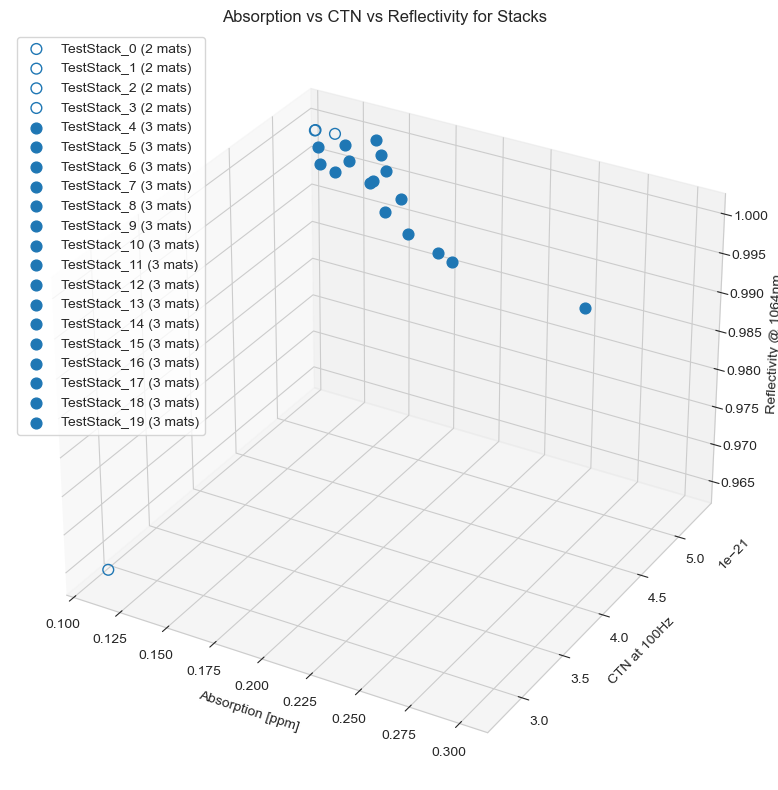

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def to_scalar(x):
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan
    return float(arr.flat[0])


stack_props = []
for stack_name, stack_params in ultimate_dict.items():
    
    absorption = to_scalar(stack_params.get('Absorption', stack_params.get('absor', np.nan)))
    ctn = to_scalar(stack_params.get('BrownianNoise_at_Frequency', [np.nan])[0])
    ## for noise in [f'{Noise}_at_Frequency'] keys extract noise 

    Te = to_scalar(stack_params.get('ThermoElasticNoise_at_Frequency', [np.nan]))
    TO = to_scalar(stack_params.get('ThermoOpticNoise_at_Frequency', [np.nan]))
    TR = to_scalar(stack_params.get('ThermoRefractiveNoise_at_Frequency', [np.nan]))

, 'ThermoElastic_at_Frequency', 'ThermoRefractive_at_Frequency'
    
    
    reflectivity = to_scalar(stack_params.get('Reflectivity_1064', stack_params.get('reflectivity_lambda_0', np.nan)))
    n_materials = len(set(stack_params.get('materialLayer', [])))
    # Only plot if all values are finite numbers
    if np.all([np.isfinite(absorption), np.isfinite(ctn), np.isfinite(reflectivity)]):
        stack_props.append({
            'stack_name': stack_name,
            'absorption': absorption,
            'ctn': ctn,
            'Te': Te,
            'TO': TO,
            'TR': TR,
            'reflectivity': reflectivity,
            'n_materials': n_materials
        })
        marker = 'o'
        facecolor = 'C0' if n_materials > 2 else 'none'
        edgecolor = 'C0'
        ax.scatter(absorption, ctn, reflectivity, marker=marker, s=60,
                   facecolors=facecolor, edgecolors=edgecolor,
                   label=f"{stack_name} ({n_materials} mats)")

stack_df = pd.DataFrame(stack_props)
display(stack_df)

ax.set_xlabel("Absorption [ppm]")
ax.set_ylabel("CTN at 100Hz")
ax.set_zlabel("Reflectivity @ 1064nm")
ax.set_title("Absorption vs CTN vs Reflectivity for Stacks")
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))

# ensure lists are passed to legend (not dict_views)
ax.legend(list(unique.values()), list(unique.keys()), loc='best')
ax.legend(unique.values(), unique.keys(), loc='best')
plt.tight_layout()
plt.show()



In [46]:
stack_df['ctn_normalized'] = stack_df['ctn'] / 6.3791814390761024e-21
stack_df = stack_df.sort_values(by='ctn_normalized')
display(stack_df)


,stack_name,absorption,ctn,Te,TO,TR,reflectivity,n_materials,ctn_normalized
0,TestStack_0,0.11,2.778721e-21,NaN,NaN,NaN,0.96464,2,0.435592
7,TestStack_7,0.30,4.021353e-21,NaN,NaN,NaN,1.00000,3,0.630387
5,TestStack_5,0.23,4.123134e-21,NaN,NaN,NaN,1.00000,3,0.646342
6,TestStack_6,0.22,4.180385e-21,NaN,NaN,NaN,1.00000,3,0.655317
4,TestStack_4,0.20,4.298477e-21,NaN,NaN,NaN,1.00000,3,0.673829
8,TestStack_8,0.18,4.478079e-21,NaN,NaN,NaN,1.00000,3,0.701983
11,TestStack_11,0.18,4.662457e-21,NaN,NaN,NaN,1.00000,3,0.730886
13,TestStack_13,0.16,4.750023e-21,NaN,NaN,NaN,1.00000,3,0.744613
9,TestStack_9,0.14,4.779722e-21,NaN,NaN,NaN,1.00000,3,0.749269
10,TestStack_10,0.16,4.779798e-21,NaN,NaN,NaN,1.00000,3,0.749281


In [ ]:
from scipy.spatial import ConvexHull

all_points = np.array([[1-bs[4]["reflectivity"], bs[4]["absorption"], np.log10(bs[4]["thermal_noise"])] for bs in best_states])
# Find the Pareto front for updated_points (minimize both objectives)
# Compute the convex hull of the 3D points (1-Reflectivity, Absorption, log(Thermal Noise))

hull = ConvexHull(all_points)
hull_vertices = all_points[hull.vertices]

def is_pareto_efficient(points):
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(points[is_efficient] < c, axis=1) | np.all(points[is_efficient] == c, axis=1)
            is_efficient[i] = True  # Keep self
    return is_efficient

pareto_mask = is_pareto_efficient(all_points)
pareto_points = all_points[pareto_mask]

# Convex hull is not always a good approximation for the Pareto front in multi-objective optimization,
# especially if the true front is non-convex. The convex hull will include points that are not truly Pareto optimal.
# For visualization or rough estimation, it can be used, but for strict Pareto front extraction, use non-dominated sorting.
# Perform non-dominated sorting
nds2 = NonDominatedSorting()
val_fronts_all = nds2.do(all_points)

# Extract the best Pareto front (the first front)
best_val_front_all = val_fronts_all[0]
print(best_val_front_all)
#pareto_points = all_points[val_fronts_all[0], :]

fig, ax = plt.subplots(figsize=(10, 15), nrows=3)
#ax[0].scatter(rwds[:,0], rwds[:,1], c="r", s=1, label="Samples All", alpha=0.2)
#ax[0].plot(rwds[val_fronts[0], 0], rwds[val_fronts[0], 1], label=f"Sampled Pareto", ms=10, color="r", marker=".", ls="none")
#plot1 = ax[0].plot(all_points[val_fronts_all[0], 0], all_points[val_fronts_all[0], 1], label=f"Cumulative Pareto", ms=10, color="C5", marker=".", ls="none", picker=True)
scatter1 = ax[0].scatter(pareto_points[:, 0], pareto_points[:, 1], label=f"Cumulative RL", c="C5", s=20, picker=True)
ax[0].scatter(all_points[:, 0], all_points[:, 1], label=f"Cumulative RL", s=1, color="C5", alpha=0.2)
#ax[0].plot(st_pareto[:, 0], st_pareto[:, 1], 'o', markersize=5, label='Random Pareto', color="b")
#ax[0].scatter(sol_vals["reflectivity"], sol_vals["absorption"], c="b", s=1, label="Random All", alpha=0.2)
scatter2 = ax[0].scatter(1-ngsa_output["Reflectivity"], ngsa_output["Absorption"], c="g", s=20, label="NGSAII", picker=True)
scatter3 = ax[0].scatter(1-moead_output["Reflectivity"], moead_output["Absorption"], c="c", s=20, label="MOEAD", picker=True)
#plot2 = ax[0].plot(1-ngsa_output["Reflectivity"], ngsa_output["Absorption"], label="NGSAII", ms=10, color="g", marker=".", ls="none", picker=True)
ab_target = env.optimise_targets["absorption"]
ref_target = 1 - env.optimise_targets["reflectivity"]
therm_target = np.log10(env.optimise_targets["thermal_noise"])
ax[0].axhline(ab_target, label="Absorption Target", color="k", linestyle="--")
ax[0].axvline(ref_target, label="Reflectivity Target", color="k", linestyle="--")


ax[0].set_xlabel("1 - Reflectivity")
ax[0].set_ylabel("Absorption [ppm]")

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend()

scatter1 = ax[1].scatter(pareto_points[:, 0], 10**pareto_points[:, 2], label=f"Cumulative RL", c="C5", s=20, picker=True)
ax[1].scatter(all_points[:, 0], 10**all_points[:, 2], label=f"Cumulative RL", s=1, color="C5", alpha=0.2)
ax[1].axhline(10**therm_target, label="Thermal noise Target", color="k", linestyle="--")
ax[1].axvline(ref_target, label="Reflectivity Target", color="k", linestyle="--")
ax[1].set_xscale("log")
ax[1].set_xlabel("1 - Reflectivity")
ax[1].set_ylabel("Thermal Noise [log10]")

scatter1 = ax[2].scatter(pareto_points[:, 1], pareto_points[:, 2], label=f"Cumulative RL", c="C5", s=20, picker=True)
ax[2].scatter(all_points[:, 1], all_points[:, 2], label=f"Cumulative RL", s=1, color="C5", alpha=0.2)
ax[2].axhline(therm_target, label="Thermal noise Target", color="k", linestyle="--")
ax[2].axvline(ab_target, label="Absorption Target", color="k", linestyle="--")
ax[2].set_xscale("log")
ax[2].set_xlabel("Absorption [ppm]")
ax[2].set_ylabel("Thermal Noise 100Hz [log10]")

In [ ]:


env.optimise_targets

In [ ]:
env.optimise_targets["thermal_noise"]

In [ ]:
np.log((10**pareto_points[:,2])/env.optimise_targets["thermal_noise"])

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
# Transform axes to log scale manually for 3D scatter
x = pareto_points[:, 0]/(1-env.optimise_targets["reflectivity"])
y = pareto_points[:, 1]/env.optimise_targets["absorption"]
z = 10**(pareto_points[:, 2] - (np.log10(env.optimise_targets["thermal_noise"])))

# Avoid log(0) by setting a small minimum value
#x_log = np.log10(np.clip(x, 1e-10, None))
#y_log = np.log10(np.clip(y, 1e-10, None))
x_log = np.clip(x, 1e-10, None)
y_log = np.clip(y, 1e-10, None)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x_log, y_log, z, c='C5', s=20, alpha=0.5, label='Cumulative RL')

ax.set_xlim(0,1)
ax.set_xlabel("log10(1 - Reflectivity)")
ax.set_ylabel("log10(Absorption [ppm])")
ax.set_zlabel("log(Thermal Noise [100Hz])")
ax.legend()

plt.tight_layout()
plt.show()
# Use %matplotlib widget for interactive 3D rotation (already set in cell 1)
